In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

from libs.vars import *

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [3]:
pub_dir = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

In [4]:
# read in NA ECO_LEVEL 3 raster files
gdf = gpd.read_file('./data/NA_CEC_Eco_Level3/')

wus_eco = gdf[gdf['NA_L3NAME'].isin(eco_regions)]
cascades_shp = gdf[gdf['NA_L3NAME'] == 'Cascades']

In [5]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)
cascades_shp = cascades_shp.to_crs(crs_proj4)

In [6]:
slps = xr.open_dataset('./data/ERA/ERA5_mslp_pacific.nc', decode_times=True)
# slps['date'] = pd.to_datetime(slps.date.astype('str'), format='%Y%m%d')
slps = slps.rename({'valid_time':'time'})
slps = slps.sel(time=slice('1960-10-01','2019-09-01'))

In [7]:
slps['msl'] = slps['msl']/100

In [8]:
slp_anoms = (slps.msl.groupby('time.month') - slps.msl.groupby('time.month').mean()).drop('month')

In [9]:
hsnow_mar = slp_anoms.sel(time=((slp_anoms['time'].dt.month==3) &
                                (slp_anoms['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_jan = slp_anoms.sel(time=((slp_anoms['time'].dt.month==1) &
                                (slp_anoms['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_oct = slp_anoms.sel(time=((slp_anoms['time'].dt.month==10) &
                                (slp_anoms['time'].dt.year.isin([1981, 1984, 1988, 1996, 1998, 2005, 2007, 2010]))))

In [10]:
lsnow_mar = slp_anoms.sel(time=((slp_anoms['time'].dt.month==3) &
                                (slp_anoms['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_jan = slp_anoms.sel(time=((slp_anoms['time'].dt.month==1) &
                                (slp_anoms['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_oct = slp_anoms.sel(time=((slp_anoms['time'].dt.month==10) &
                                (slp_anoms['time'].dt.year.isin([1980, 1991, 2000, 2004, 2014]))))

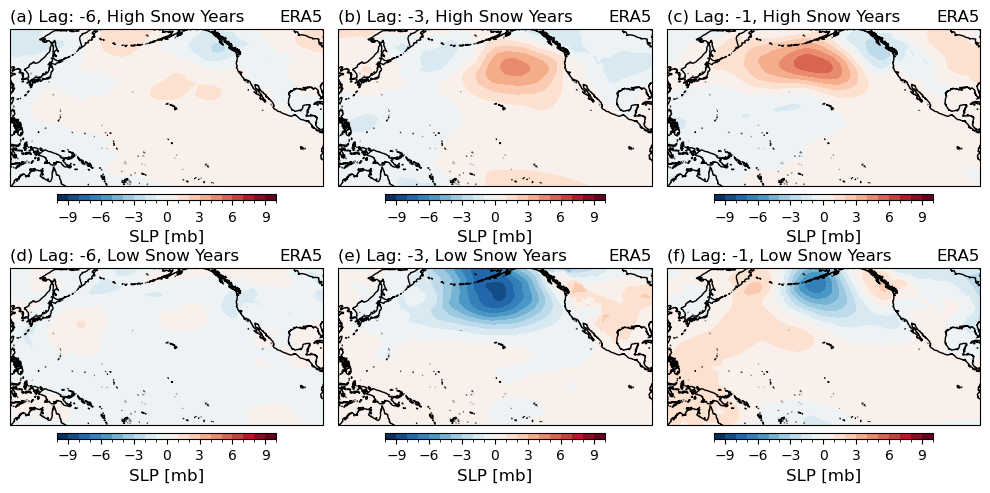

In [11]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_slp = {'shrink':0.7, 'aspect':40,
               'pad':0.04,
               'orientation':'horizontal'}
slp_levels = np.arange(-10,10.1,1)

p1 = hsnow_oct.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)


ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())
p2 = hsnow_jan.mean(dim='time').plot.contourf(
    ax2=ax2,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)

ax3.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = hsnow_mar.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

# cascades_shp.boundary.plot(ax=ax1, color='tab:brown', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax2, color='tab:brown', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax3, color='tab:brown', transform=ccrs.PlateCarree())

ax1.set_title('(a) Lag: -6, High Snow Years', loc='left')
ax2.set_title('(b) Lag: -3, High Snow Years', loc='left')
ax3.set_title('(c) Lag: -1, High Snow Years', loc='left')
ax1.set_title('ERA5', loc='right')
ax2.set_title('ERA5', loc='right')
ax3.set_title('ERA5', loc='right')

ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

# cbar_kwargs_slp = {'shrink':0.7, 'aspect':70,
#                'pad':0.04,
#                'orientation':'horizontal'}
# slp_levels = np.arange(-10,10.1,1)

p4 = lsnow_oct.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p4,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)

ax5.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())
p5 = lsnow_jan.mean(dim='time').plot.contourf(
    ax5=ax5,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p5,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax4 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)

ax6.set_extent([120, 280, -20, 60], crs=ccrs.PlateCarree())

p6 = lsnow_mar.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = slp_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p6,**cbar_kwargs_slp)
cb.set_label(r'SLP [mb]', size=12)
cb.ax.tick_params(labelsize=10)

# cascades_shp.boundary.plot(ax=ax4, color='tab:brown', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax5, color='tab:brown', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax6, color='tab:brown', transform=ccrs.PlateCarree())

ax4.set_title('(d) Lag: -6, Low Snow Years', loc='left')
ax5.set_title('(e) Lag: -3, Low Snow Years', loc='left')
ax6.set_title('(f) Lag: -1, Low Snow Years', loc='left')
ax4.set_title('ERA5', loc='right')
ax5.set_title('ERA5', loc='right')
ax6.set_title('ERA5', loc='right')

plt.tight_layout()
plt.savefig(pub_dir_main+'fig9a_9f.eps',
            bbox_inches='tight',
            facecolor='w')

In [12]:
ssts = xr.open_dataset('./data/SST_anoms.nc')

In [13]:
hsnow_mar_sst = ssts.sst.sel(time=((ssts['time'].dt.month==3) &
                                (ssts['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_jan_sst = ssts.sst.sel(time=((ssts['time'].dt.month==1) &
                                (ssts['time'].dt.year.isin([1982, 1985, 1989, 1997, 1999, 2006, 2008, 2011]))))

hsnow_oct_sst = ssts.sst.sel(time=((ssts['time'].dt.month==10) &
                                (ssts['time'].dt.year.isin([1981, 1984, 1988, 1996, 1998, 2005, 2007, 2010]))))

In [14]:
lsnow_mar_sst = ssts.sst.sel(time=((ssts['time'].dt.month==3) &
                                (ssts['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_jan_sst = ssts.sst.sel(time=((ssts['time'].dt.month==1) &
                                (ssts['time'].dt.year.isin([1981, 1992, 2001, 2005, 2015]))))

lsnow_oct_sst = ssts.sst.sel(time=((ssts['time'].dt.month==10) &
                                (ssts['time'].dt.year.isin([1980, 1991, 2000, 2004, 2014]))))

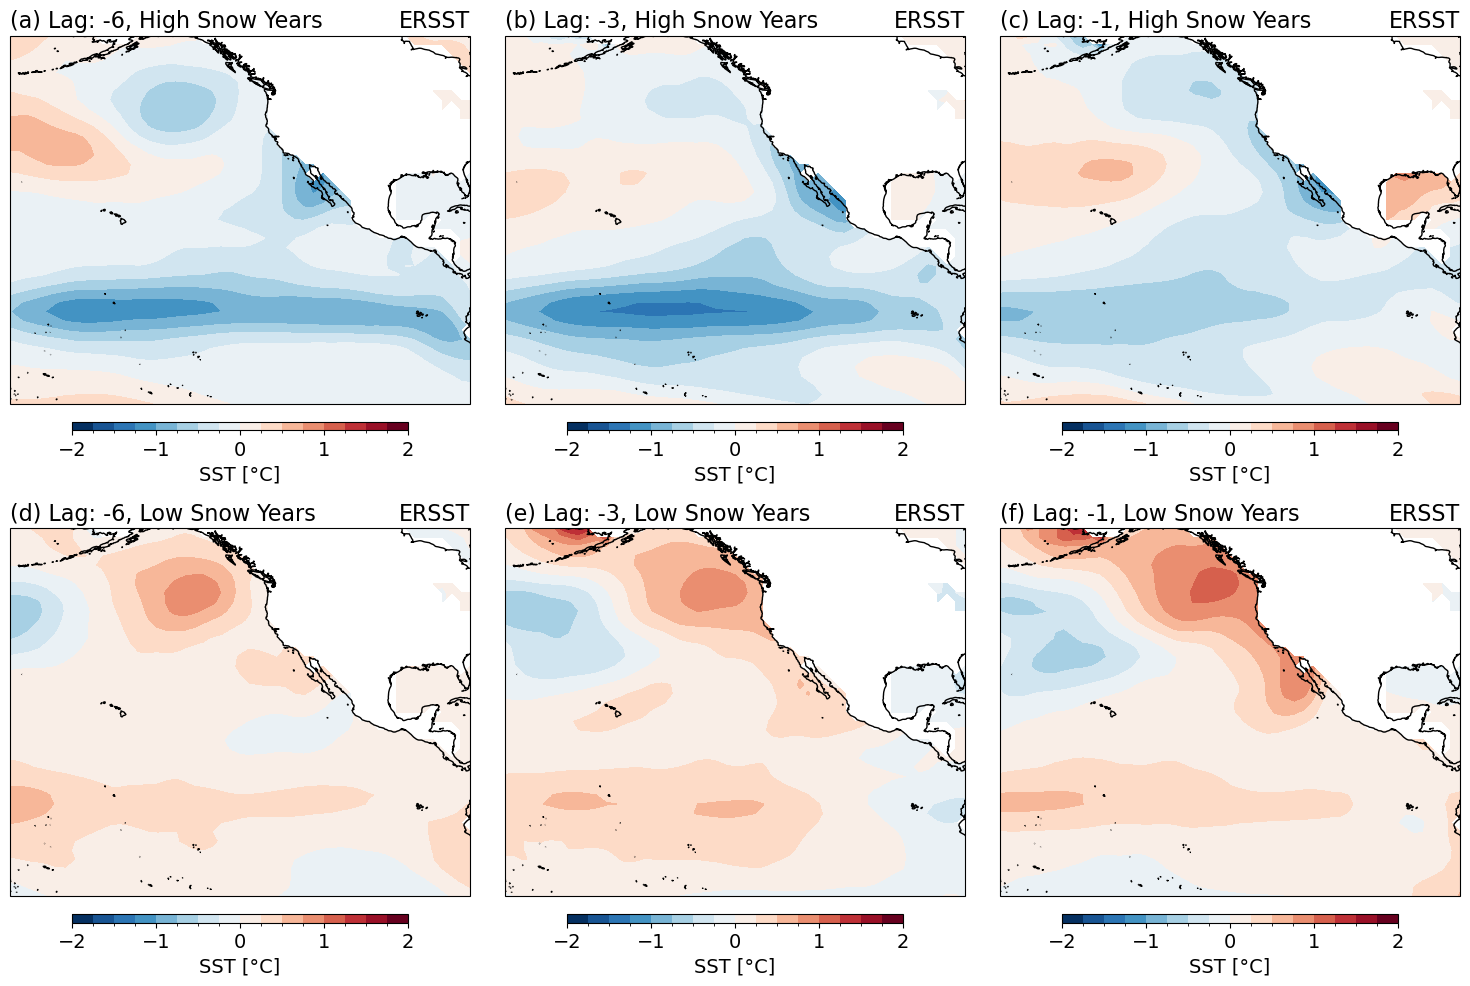

In [15]:
fig = plt.figure(figsize=(15,10))

gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':40,
                   'label':r'SST [°C]',
                   'pad':0.04,
                   'orientation':'horizontal',
                   'ticks':[-2,-1,0,1,2],
                  }
sst_levels = np.arange(-2,2.1,0.25)

p1 = hsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax1,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p1,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p2 = hsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax2,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p2,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax3.coastlines(resolution='50m', color='black', linewidth=1)
ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p3 = hsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax3,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p3, **cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

# cascades_shp.boundary.plot(ax=ax1, color='tan', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax2, color='tan', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax3, color='tan', transform=ccrs.PlateCarree())

ax4 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax4.coastlines(resolution='50m', color='black', linewidth=1)

ax4.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs_sst = {'shrink':0.7, 'aspect':40,
                   'label':r'SST [°C]',
                   'pad':0.04,
                   'orientation':'horizontal',
                   'ticks':[-2,-1,0,1,2],
                  }
sst_levels = np.arange(-2,2.1,0.25)

p4 = lsnow_oct_sst.mean(dim='time').plot.contourf(
    ax=ax4,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p4,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax5 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax5.coastlines(resolution='50m', color='black', linewidth=1)
ax5.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p5 = lsnow_jan_sst.mean(dim='time').plot.contourf(
    ax=ax5,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p5,**cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

ax6 = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree(central_longitude=180))
# ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax6.coastlines(resolution='50m', color='black', linewidth=1)
ax6.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

p6 = lsnow_mar_sst.mean(dim='time').plot.contourf(
    ax=ax6,
    levels = sst_levels,
    transform=ccrs.PlateCarree(),
    add_colorbar=False)
cb = plt.colorbar(p6, **cbar_kwargs_sst)
cb.set_label(r'SST [°C]', size=14)
cb.ax.tick_params(labelsize=14)

# cascades_shp.boundary.plot(ax=ax4, color='tan', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax5, color='tan', transform=ccrs.PlateCarree())
# cascades_shp.boundary.plot(ax=ax6, color='tan', transform=ccrs.PlateCarree())

ax1.set_title('(a) Lag: -6, High Snow Years', loc='left', fontsize=16)
ax2.set_title('(b) Lag: -3, High Snow Years', loc='left', fontsize=16)
ax3.set_title('(c) Lag: -1, High Snow Years', loc='left', fontsize=16)
ax1.set_title('ERSST', loc='right', fontsize=16)
ax2.set_title('ERSST', loc='right', fontsize=16)
ax3.set_title('ERSST', loc='right', fontsize=16)


ax4.set_title('(d) Lag: -6, Low Snow Years', loc='left', fontsize=16)
ax5.set_title('(e) Lag: -3, Low Snow Years', loc='left', fontsize=16)
ax6.set_title('(f) Lag: -1, Low Snow Years', loc='left', fontsize=16)
ax4.set_title('ERSST', loc='right', fontsize=16)
ax5.set_title('ERSST', loc='right', fontsize=16)
ax6.set_title('ERSST', loc='right', fontsize=16)

plt.tight_layout()
plt.savefig(pub_dir_main+'fig10a_10f.eps',
            bbox_inches='tight',
            facecolor='w')